## やりたいこと
- PCAモデルの保存とロード
- ロードしたモデルでの推論処理
- 平均二乗誤差の算出と判定閾値の計算  
    単純にOK/NGのMSEの差の中央部を閾値にする
- 閾値による分類テスト  

処理の流れとしては
1. X_trainからOKデータのみを分離、学習
1. X_train全体を通し、OK/NGのMSEを算出して分離境界を決定
1. X_testを通してMSEを算出し、X_trainの分離境界を用いて分類を行う

手っ取り早く検証するためにPCAモデルを題材とした  
オートエンコーダでも基本的な処理は同じになる

In [1]:
# cording = UTF-8
import os,re,random,copy                    #標準ライブラリ
import scipy,librosa,sklearn,joblib,h5py    #サードパーティライブラリ
import numpy as np
import pandas as pd                         #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras                #御呪い
import matplotlib.pyplot as plt

print ("Scipy version:{0}".format(scipy.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Tensorflow version:{0}".format(tf.__version__)) #赤線は無視
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("joblib version:{0}".format(joblib.__version__))
print ("h5py version:{0}".format(h5py.__version__))


Scipy version:1.4.1
Numpy version:1.18.2
Pandas version:1.0.3
Tensorflow version:2.1.0
tf.keras version:2.2.4-tf
Scikit-Learn version:0.22.2.post1
joblib version:0.14.1
h5py version:2.10.0


In [2]:
#初期設定
n_components = 0.999    #疑似AEの保持分散

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
datafile = "dataset2.npz"

In [3]:
#データロード
load_data = np.load(os.path.join(data_dir,datafile))
X_data =load_data['X']
y_data = load_data['y']
del load_data
print("Data loaded!!")

Data loaded!!


In [4]:
#データの分離
X_train,X_test,y_train,y_test = \
    sklearn.model_selection.train_test_split(
        X_data.reshape(len(X_data),-1), #アフィン変換
        y_data,
        test_size=0.05)
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)
del X_data,y_data

X_train_ae = X_train[np.logical_not(y_train)]
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)

Training data amounts :3800
Test data amounts :200
X_train for Autoencoder was splited!!
amount/shape:(1893, 60021)


In [5]:
#分類器の定義と学習
def Pusedo_AE(n_components):
    x = sklearn.decomposition.PCA(n_components = n_components)
    return x

model = Pusedo_AE(n_components = n_components)

hist = model.fit(X_train_ae)

print("PusedoAE learning is over!\n\
n_components = {0}"
.format(hist.n_components_))

PusedoAE learning is over!
n_components = 1588


トレーニングデータのうちFalseデータのみを使って事前学習

In [6]:
#モデルの保存
joblib.dump(
    model,os.path.join(modeldir,"PCAmodel.dat")
)

['./models\\PCAmodel.dat']

720MB。意外とでかい

In [7]:
#モデルのロード
loded_model = joblib.load(os.path.join(modeldir,"PCAmodel.dat"))

ロードしたモデルを用い、X_trainを使った分類境界の算出を行う

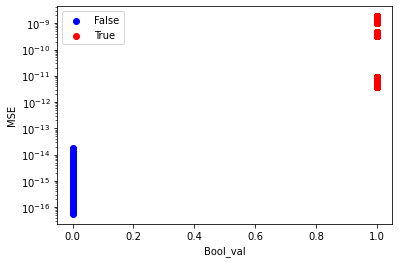

In [8]:
#X_trainをデコードし、MSEを計算
X_train_decode =  loded_model.inverse_transform(
    loded_model.transform(X_train)
)

diff_mse = np.zeros(y_train.shape)
for i in range(X_train.shape[0]):
    diff_mse[i] = sklearn.metrics.mean_squared_error(
        X_train[i],X_train_decode[i]
    )

#可視化
plt.scatter(
    y_train[np.logical_not(y_train)],
    diff_mse[np.logical_not(y_train)],
    color = "#0000ff",
    linestyle='None',
    label = "False"
    )
plt.scatter(
    y_train[y_train],
    diff_mse[y_train],
    color = "#ff0000",
    linestyle='None',
    label = "True"
    )
plt.xlabel("Bool_val")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()

さすがに時間がかかった(それでも1分程度)  
1e-12近辺に分離境界が表れそう  

分類境界はFalseのMSE最大値～TrueのMSE最小値の中間とする

In [11]:
#分離境界の計算
thresh_diff = (
        (
        (diff_mse[y_train].min() - diff_mse[np.logical_not(y_train)].max()) / 2
        ) + diff_mse[np.logical_not(y_train)].max()
    )
print("threshold:{}".format(thresh_diff))

threshold:1.8962469436011093e-12


この結果を用いてX_testを判定する  
流れ：
1. 事前学習済みPCにX_testを通す
1. 得られたデコード結果からMSEを計算
1. 事前に算出した閾値より低いものをFalse、高いものをTrueとしてy‗predを得る
1. y_predを可視化し、分類結果を判定する

Prediction is finished!!


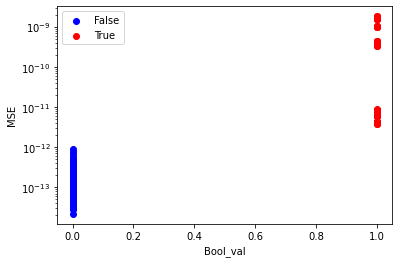

In [15]:
#ロードしたモデルで推論
X_test_decode = loded_model.inverse_transform(
    loded_model.transform(X_test)
)
print ("Prediction is finished!!")

#MSEを計算
pred_mse = np.zeros(y_test.shape)
for i in range(X_test_decode.shape[0]):
    pred_mse[i] = sklearn.metrics.mean_squared_error(
        X_test[i],X_test_decode[i]
    )

#閾値で判定
y_pred = np.zeros(len(pred_mse),dtype=bool)
for i in range(len(pred_mse)):
    if pred_mse[i] < thresh_diff:
        y_pred[i] = False
    else:
        y_pred[i] = True

#結果の可視化
plt.scatter(
    y_pred[np.logical_not(y_pred)],
    pred_mse[np.logical_not(y_pred)],
    color = "#0000ff",
    linestyle='None',
    label = "False"
    )
plt.scatter(
    y_pred[y_pred],
    pred_mse[y_pred],
    color = "#ff0000",
    linestyle='None',
    label = "True"
    )
plt.xlabel("Bool_val")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()

一応今回のテスト結果では分類できているが、Falseの1e-12近辺までMSEが近接しており、X_testの内容次第では誤判定もありえた。  
y_testを考慮した分類境界はもうちょっと高め。9e-12ぐらい？

## わかったこと
- MSEから分類境界を求めるのは意外と簡単
- joblibで学習結果を保存・ロードできる
- sklearnのPCAは追加学習ができない
- np.zerosはdtype = boolを指定しないとflort64になってしまう
- コードは載せてないが、sklearnの線形分離機で学習すると「傾き・切片」の形で出るため使いづらい

## 次にやること
- AE.pyへの反映 モデルの引数は同じにしてるのでAE分類でも同一コードで処理できる(はず)
- 誤判定をしたデータが表れた際の処理方法の検討